In [1]:
%%time
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.ops import transform

from shapely.geometry import Point, Polygon
import datetime

from io import StringIO
from pathlib import Path, PureWindowsPath
import os
import sys
from functools import partial

# Import custom functions from `scripts` folder
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from scripts.clean_tweets import geometrize_tweets, convert_shapefile_crs, find_frequencies
from scripts.home_location import assign_home_location
from scripts.summary_stats import summary_stats

data_path = Path("C:/Users/emman/Box/Spring 2020/Displacement Studio/Datasets/")

Wall time: 1.22 s


In [2]:
data_path

WindowsPath('C:/Users/emman/Box/Spring 2020/Displacement Studio/Datasets')

In [3]:
def filter_and_home_assign(data, shapefile, lower, upper):
    """
    Find subset of data to analyze based on lower/upper bounds on tweets/user, 
    then add home locations.
    
    Parameters
    ----------
    data : pd.DataFrame or gpd.GeoDataFrame
        DataFrame containing tweets; must contain column `u_id` for user id
    
    shapefile : gpd.GeoDataFrame
        Shapefile for tracts in tweets location.
        Must be in WGS84 (epsg:4326) format (to align with tweet lat/lon).
    
    lower, upper : int or float
        Lower (inclusive) and upper (exclusive) bounds on tweets/user.
        
    Returns
    -------
    filtered : gpd.GeoDataFrame
        Collection of tweets filtered by lower/upper and with tweet geographies.
        Contains new columns:
            - 'timestamp' : pd.Timestamp for time of tweet published
            - 'date' : date (int) of tweet published
            - 'hour' : 24-hour (int) of tweet published
            - 'home' : name of home location codigo (some may be NaN)
            - 'is_home' : boolean indicating whether tweet was made at home
    """
    # Filter based on lower and upper bound on tweets/user
    filtered = data.groupby('u_id').filter(lambda group: (len(group) >= lower) & (len(group) < upper))
    
    # Geometrize tweets (inplace) based on lat/lon
    filtered = geometrize_tweets(filtered)
    
    # Spatial join with tracts
    filtered = gpd.sjoin(filtered, shapefile, how='left', op='intersects')
    
    # Add datetime
    filtered['timestamp'] = pd.to_datetime(filtered['created_at'] // 1000, unit='s')
    filtered['date'] = filtered['timestamp'].dt.date
    filtered['hour'] = filtered['timestamp'].dt.hour
    
    # Add home location
    filtered['home'] = assign_home_location(filtered, SA2='SA2_MAIN16')
    filtered['is_home'] = filtered['SA2_MAIN16'] == filtered['home']
    
    return filtered

In [4]:
tweets_2014 = pd.read_csv(data_path/'AUST_TWT_2014.csv')

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


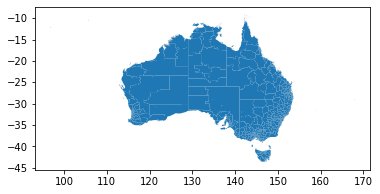

In [5]:
au_shape_sa2 = gpd.read_file('C:\\Users\\emman\\box\\Spring 2020\\Displacement Studio\\Shared 228 Sydney Folder\\SA2 Shapefiles\\SA2_2016_AUST.dbf')
# Crikey, our area is too big
au_shape_sa2.plot()
# We also need to change the crs 
au_shape_sa2.crs = {'init': 'epsg:4326'}
# have the shapefile only have areas that are in the state of New South Wales, and furthermore, in Greater Sydney
au_shape_sa2 = au_shape_sa2[au_shape_sa2.STE_NAME16 == 'New South Wales']
au_shape_sa2 = au_shape_sa2[au_shape_sa2.GCC_NAME16 == 'Greater Sydney']

In [6]:
tweets_2014.head()

,Unnamed: 0,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,geometry,timestamp,date
0,1581810,418173061754392576,1.388535e+12,http://t.co/UeegURNfzK,266767217,Di Giblin,1.300218e+12,Public education activitist - inspired by the ...,309,ll,AUS,giblin5878,725,150.737471,-33.745448,POINT (150.73747097 -33.74544757),2014-01-01 00:13:21,2014-01-01 00:00:00
1,1581811,418178113168609281,1.388536e+12,ZERRIE IS ADORABLE IDC WHAT PEOPLE SAY,598957020,idekmiley,1.338779e+12,dont worry when larry is confirmed i will tell...,1059,ll,AUS,fknlarrybliss,1304,150.942038,-33.817507,POINT (150.94203844 -33.81750747),2014-01-01 00:33:26,2014-01-01 00:00:00
2,1581813,418183818852331520,1.388538e+12,@vicky_lovell I miss you mum!! X,122517574,JJL.,1.268440e+12,"Eyes closed, dancing on my own. Insta: JamesJo...",770,ll,AUS,Lovelly91_,1234,151.271393,-33.886303,POINT (151.2713926 -33.88630348),2014-01-01 00:56:06,2014-01-01 00:00:00
3,1581817,418172035416604672,1.388535e+12,"“@Brianhopecomedy: I'm drunk, naked and waitin...",116956076,Deborah,1.266980e+12,Independent & successful woman; enjoys Work/Li...,50,ll,AUS,Mssmth,51,151.244363,-33.839981,POINT (151.24436306 -33.83998111),2014-01-01 00:09:17,2014-01-01 00:00:00
4,1581818,418175915793711105,1.388536e+12,Happy new year melege!! 😂 Beket eng gende gend...,405318986,Camille Salazar,1.320468e+12,"If you never try, you'll never know. #ITSMOREF...",423,ll,AUS,CmllSlzr,167,151.097339,-33.687701,POINT (151.09733943 -33.68770083),2014-01-01 00:24:42,2014-01-01 00:00:00


In [7]:
pct_50, pct_99 = summary_stats(tweets_2014)

1951136 total tweets
56234 unique users

Median number of tweets/user: 5.0 tweets
99th percentile of tweets/user: 501.66999999999825 tweets


In [8]:
twt2014 = filter_and_home_assign(tweets_2014, au_shape_sa2, pct_50, pct_99)

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


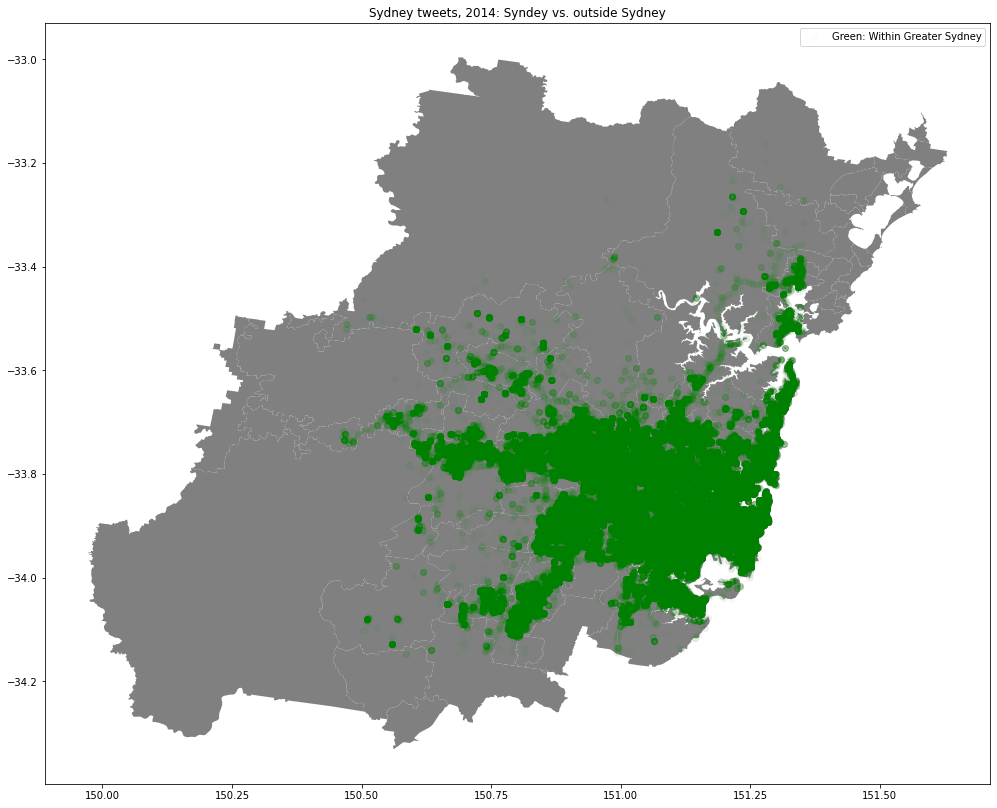

In [9]:
### Plot all 2014 tweets ###
# Green tweets: Joined to an SA2
# Orange tweets: No SA2 Assigned
# Gray: Australia shapefile

fig, ax = plt.subplots(figsize=(20, 14))
au_shape_sa2['geometry'].plot(ax=ax, color='gray')
sample = twt2014.sample(frac=1.00, random_state=42)
sample[~sample['SA2_MAIN16'].isnull()].plot(ax=ax, marker='o', color='green', alpha=0.01, label='Green: Within Greater Sydney')
sample[sample['SA2_MAIN16'].isnull()].plot(ax=ax, marker='o', color='orange', alpha=0.01, label='Orange: Outside Greater Sydney')
plt.legend()
plt.title('Sydney tweets, 2014: Syndey vs. outside Sydney');

From this, we see that we can use [~autwt_2014['SA2_5DIG16'].isnull()] as a filter to select just the tweets in Syndey, which is our area of interest. For all following analyses, we will restrict the population to just the tweets that fall inside Sydney depicted by the shapefile.

Our first summary statistic computes the ratio of tweets that have a home assignment.

In [10]:
num_home_assigned_tweets = (~twt2014.loc[~twt2014['SA2_MAIN16'].isnull(), 'home'].isnull()).sum()
n_tweets = len(twt2014[~twt2014['SA2_MAIN16'].isnull()])

print("{}/{} = {:.2%} of tweets have a home assignment.".format(
    num_home_assigned_tweets, n_tweets, num_home_assigned_tweets / n_tweets
))

812496/1170161 = 69.43% of tweets have a home assignment.


Next, we are interested in the ratio of users that have a home assignment.

In [11]:
num_users_with_home = (~twt2014.loc[~twt2014['SA2_MAIN16'].isnull()].groupby('u_id')['home'].first().isnull()).sum()
n_users = len(twt2014[~twt2014['SA2_MAIN16'].isnull()].groupby('u_id'))

print("{}/{} = {:.2%} of users have a home assignment.".format(
    num_users_with_home, n_users, num_users_with_home / n_users
))

7080/27717 = 25.54% of users have a home assignment.


Lastly, we want to know the ratio of tweets that were made from home (i.e. SA2_5DIG16 and home are equal).

In [12]:
twt2014.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1170161 entries, 0 to 1951134
Data columns (total 34 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   Unnamed: 0         1170161 non-null  int64         
 1   id                 1170161 non-null  int64         
 2   created_at         1170161 non-null  float64       
 3   text               1170161 non-null  object        
 4   u_id               1170161 non-null  int64         
 5   u_name             1170161 non-null  object        
 6   u_created_at       1170161 non-null  float64       
 7   u_description      1170161 non-null  object        
 8   u_followers_count  1170161 non-null  int64         
 9   type               1170161 non-null  object        
 10  c_country          1170161 non-null  object        
 11  u_screen_name      1170161 non-null  object        
 12  u_friends_count    1170161 non-null  int64         
 13  location.lon       

In [13]:
num_tweets_from_home = twt2014.loc[~twt2014['SA2_MAIN16'].isnull(), 'is_home'].sum()

print("{}/{} = {:.2%} of tweets are posted from the home tract.".format(
    num_tweets_from_home, n_tweets, num_tweets_from_home / n_tweets
))

515750/1170161 = 44.08% of tweets are posted from the home tract.


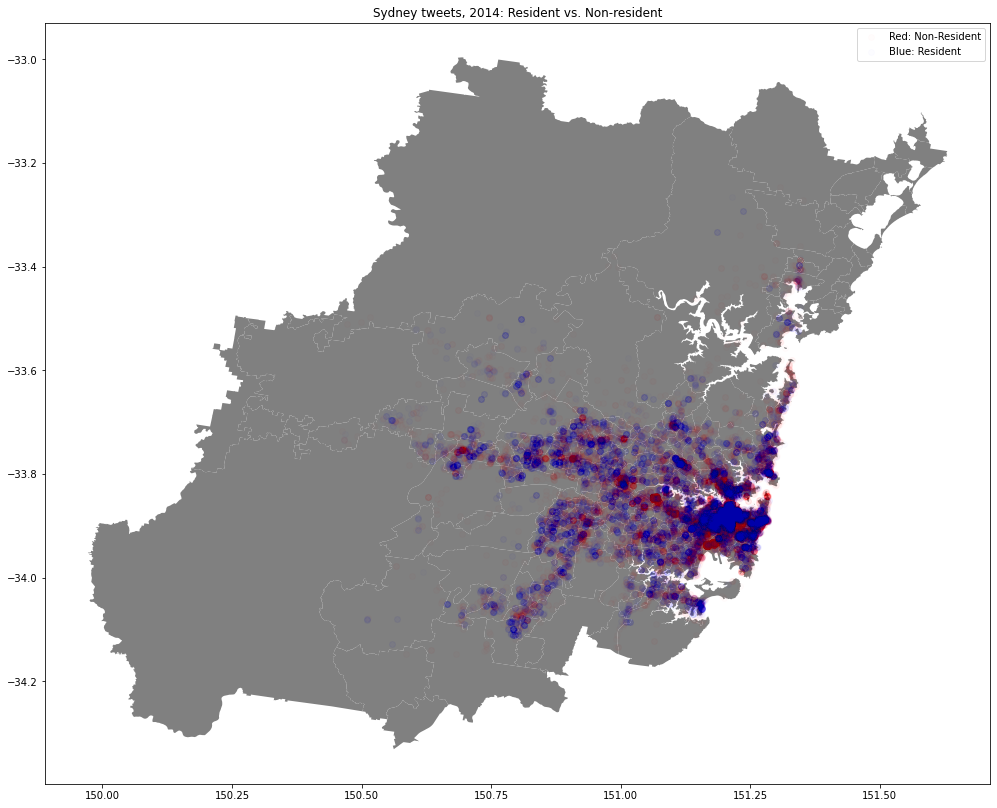

In [14]:
### Plot a 5% sample of 2014 tweets ###
# Blue tweets: Resident
# Red tweets: Non-resident
# Gray: Sydney shapefile

fig, ax = plt.subplots(figsize=(20, 14))

au_shape_sa2['geometry'].plot(ax=ax, color='gray')

sample = twt2014[~twt2014['SA2_MAIN16'].isnull()].sample(frac=0.05, random_state=42)

sample[~sample['is_home']].plot(ax=ax, marker='o', color='red', alpha=0.01, label='Red: Non-Resident')

sample[sample['is_home']].plot(ax=ax, marker='o', color='blue', alpha=0.01, label='Blue: Resident')

plt.legend()
plt.title('Sydney tweets, 2014: Resident vs. Non-resident');

Our analysis concludes with a visual representation of this last information; namely, how are the tweets spread out across the entire metropolitan area of Buenos Aires with respect to residence/nonresidence?

# Saving Output

For future reference, we save an output CSV of all the tweets, spatially joined to the Sydney shapefiles. There are two additional columns:

    home: NaN (missing value) if the tweet user has no home location, else the home tract ('SA2_MAIN16')
    is_home: an indicator (True/False) determining whether home == SA2_MAIN16


In [15]:
#twt2014.to_csv(data_path/'au_twt2014_joined.csv.gz', index=False, compression='gzip')